**使用GoogleNet进行图像分类**

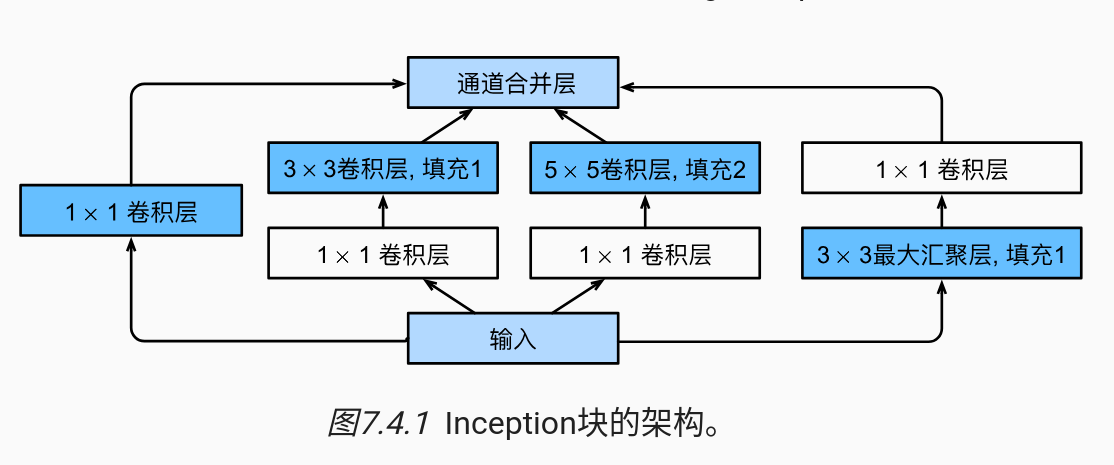
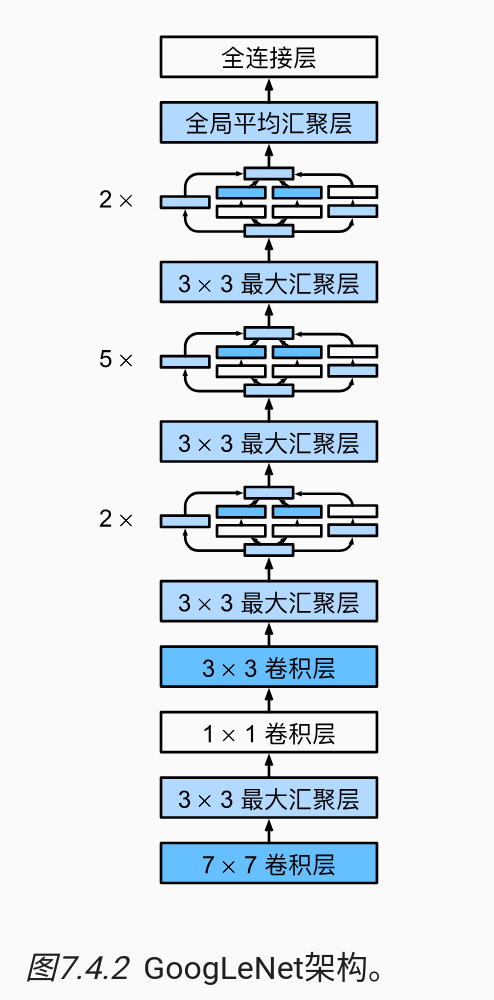

**一、数据预处理**

In [2]:
from frame_special import *
import numpy as np
import torchinfo

In [3]:
# 加载原始数据
train_arrays,train_labels = load_data()
test_arrays = load_test()

Load test data: 100%|██████████| 300000/300000 [00:21<00:00, 14194.37it/s]


In [4]:
# 构造训练数据迭代器
batch_size = 64
train_dataset = TrainDataset(train_arrays,train_labels)
train_iter = data.DataLoader(train_dataset,batch_size,shuffle = True)

Load-Data-iter: 100%|██████████| 50000/50000 [00:03<00:00, 16002.05it/s]

load 50000 images!


In [5]:
# 构造测试数据迭代器
test_dataset = TestDataset(test_arrays)
test_iter = data.DataLoader(test_dataset,batch_size,shuffle = False)

Load-Data-iter: 100%|██████████| 300000/300000 [00:19<00:00, 15700.64it/s]

load 300000 images!


**二、GoogLeNet网络搭建**

In [6]:
class Inception(nn.Module):
    """单个Inception块的实现"""
    # c1--c4是每条路径的输出通道数
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # 线路1，单1x1卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)

        # 线路2，1x1卷积层后接3x3卷积层
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)

        # 线路3，1x1卷积层后接5x5卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        
        # 线路4，3x3最大汇聚层后接1x1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        return torch.cat((p1, p2, p3, p4), dim=1) # 在通道维度上连结输出

In [7]:
def get_googlenet(in_channels,class_nums):
    b1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    b2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    b3 = nn.Sequential(
            Inception(192, 64, (96, 128), (16, 32), 32),
            Inception(256, 128, (128, 192), (32, 96), 64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    b4 = nn.Sequential(
            Inception(480, 192, (96, 208), (16, 48), 64),
            Inception(512, 160, (112, 224), (24, 64), 64),
            Inception(512, 128, (128, 256), (24, 64), 64),
            Inception(512, 112, (144, 288), (32, 64), 64),
            Inception(528, 256, (160, 320), (32, 128), 128),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    b5 = nn.Sequential(
            Inception(832, 256, (160, 320), (32, 128), 128),
            Inception(832, 384, (192, 384), (48, 128), 128),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten())
    return nn.Sequential(
        b1,b2,b3,b4,b5,
        nn.Linear(1024,class_nums)
    )

In [15]:
input = torch.rand((1,3,32,32))
net = get_googlenet(in_channels = 3,class_nums = 10)
print(torchinfo.summary(net,input.shape))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 8, 8]             --
│    └─Conv2d: 2-1                       [1, 64, 16, 16]           9,472
│    └─ReLU: 2-2                         [1, 64, 16, 16]           --
│    └─MaxPool2d: 2-3                    [1, 64, 8, 8]             --
├─Sequential: 1-2                        [1, 192, 4, 4]            --
│    └─Conv2d: 2-4                       [1, 64, 8, 8]             4,160
│    └─ReLU: 2-5                         [1, 64, 8, 8]             --
│    └─Conv2d: 2-6                       [1, 192, 8, 8]            110,784
│    └─ReLU: 2-7                         [1, 192, 8, 8]            --
│    └─MaxPool2d: 2-8                    [1, 192, 4, 4]            --
├─Sequential: 1-3                        [1, 480, 2, 2]            --
│    └─Inception: 2-9                    [1, 256, 4, 4]            --
│   

**三、模型训练**

In [18]:
# 定义超参数
num_epochs = 12
lr = 3e-4

# 损失函数
loss_fn = nn.CrossEntropyLoss()

In [19]:
device = try_gpu(i = 5)
loss_plt = train(net,train_iter,lr,num_epochs,loss_fn,device = device)

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [12/12]: 100%|██████████| 782/782 [00:35<00:00, 21.94it/s, LOSS=0.00295, lr=3.000000e-04]


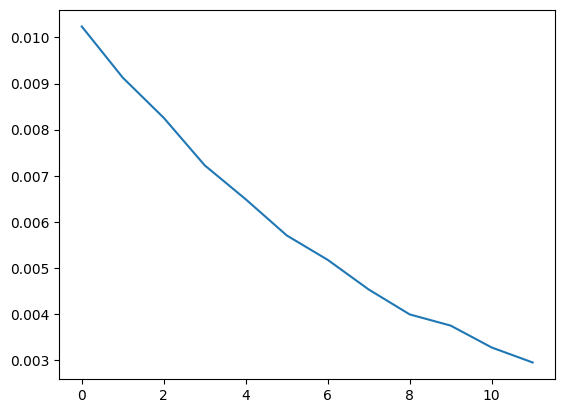

In [20]:
# 训练损失展示
import matplotlib.pyplot as plt
plt.plot(np.arange(len(loss_plt)),loss_plt)
plt.show()

In [21]:
# 保存模型
torch.save(net,"models/googlenet.pt")
print(f"model save successfully!")

model save successfully!


**四、模型评估**

In [22]:
net = torch.load("models/googlenet.pt",weights_only = False)
acc = count_accurancy(net,train_iter)
print(acc)

Eval: 100%|██████████| 782/782 [00:06<00:00, 120.20it/s]

0.9525


In [23]:
# 在验证集上测试
predict(net,test_iter,train_dataset.idx2obj)

Predict: 100%|██████████| 4688/4688 [00:32<00:00, 144.31it/s]
